In [1]:
#import required libraries

import pandas as pd
import yfinance as yf
import numpy as np
import math
#import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [3]:
stock = yf.Ticker("AAPL")
print(stock.info)

{'zip': '95014', 'sector': 'Technology', 'fullTimeEmployees': 147000, 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radi

In [4]:
stock_df = stock.history(period="3y", interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-07-31,45.999051,46.443813,45.767000,45.996632,157492000,0.0,0.0
2018-08-01,48.133423,48.769141,47.693494,48.706295,271742800,0.0,0.0
2018-08-02,48.483921,50.369327,48.428327,50.130024,249616000,0.0,0.0
2018-08-03,50.043003,50.456344,49.668339,50.275055,133789600,0.0,0.0
2018-08-06,50.277473,50.579621,50.052676,50.536114,101701600,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-26,148.270004,149.830002,147.699997,148.990005,72269700,0.0,0.0
2021-07-27,149.119995,149.210007,145.550003,146.770004,103580300,0.0,0.0
2021-07-28,144.809998,146.970001,142.539993,144.979996,118931200,0.0,0.0


In [5]:
stock_df_wk = stock.history(period="3y", interval='1wk')
stock_df.index.duplicated().sum()
df_stock_wk = stock_df_wk.loc[~stock_df_wk.index.duplicated(keep='first')]
df_stock_wk

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-07-30,46.385800,50.456344,45.701739,50.275055,896758400.0,0.0000,0.0
2018-08-06,50.277468,50.707727,49.436289,50.163860,486568400.0,0.0000,0.0
2018-08-10,NaN,NaN,NaN,NaN,NaN,0.1825,0.0
2018-08-13,50.771567,52.867340,50.381035,52.777592,557495600.0,0.0000,0.0
2018-08-20,52.903727,53.165695,51.870392,52.433147,451300800.0,0.0000,0.0
...,...,...,...,...,...,...,...
2021-07-05,140.070007,145.649994,140.070007,145.110001,418457300.0,0.0000,0.0
2021-07-12,146.210007,150.000000,143.630005,146.389999,504098200.0,0.0000,0.0
2021-07-19,143.750000,148.720001,141.669998,148.559998,441288000.0,0.0000,0.0


In [6]:
stock_df_mo = stock.history(period="3y", interval='1mo')
stock_df_mo.index.duplicated().sum()
df_stock_mo = stock_df_mo.loc[~stock_df_mo.index.duplicated(keep='first')]
df_stock_mo

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-01,48.133431,55.322140,47.693501,55.022411,2.801276e+09,0.0000,0.0
2018-08-10,NaN,NaN,NaN,NaN,NaN,0.1825,0.0
2018-09-01,55.404579,55.710211,52.224534,54.756927,2.715888e+09,0.0000,0.0
2018-10-01,55.293001,56.631968,49.990500,53.088074,3.158994e+09,0.0000,0.0
2018-11-01,53.134167,53.937061,41.299351,43.317505,3.845306e+09,0.0000,0.0
2018-12-01,44.899907,45.016744,35.681866,38.395920,3.595690e+09,0.0000,0.0
2019-01-01,37.702193,41.136747,34.564604,40.513611,3.312350e+09,0.0000,0.0
2019-02-01,40.640190,42.808995,40.389471,42.146912,1.890162e+09,0.0000,0.0
2019-03-01,42.603908,48.326640,41.435405,46.434544,2.603926e+09,0.0000,0.0


In [7]:
# calculate Bollinger Bands
# moving average
m_avg = df_stock['Close'].rolling(window=length).mean()
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [8]:
# calculate Keltner Channel
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df_stock['tr'].rolling(window=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [9]:
#ADX Calculations

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

df_stock['atr'] = df_stock['tr'].rolling(window=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean()

In [10]:
# check for 'squeeze'
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [43]:
# Momentum
highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock["pct_change"] = df_stock['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'upper_BB', 'lower_BB', 'tr0', 'tr1', 'tr2', 'tr', 'upper_KC',
       'lower_KC', 'atr', 'plus_di', 'minus_di', 'adx', 'squeeze_on',
       'squeeze_off', 'value', 'pct_change', 'profitable?'],
      dtype='object')

In [12]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [13]:
import mplfinance as mpf
%matplotlib widget

In [14]:
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

,Open,High,Close,Low
Date,,,,
2018-09-26,53.607169,54.274227,53.466480,53.306386
2018-09-27,54.291195,54.926718,54.565292,54.223273
2018-09-28,54.526487,54.781182,54.756927,54.339713
2018-10-01,55.292997,55.649570,55.125626,54.904893
2018-10-02,55.123199,55.790256,55.615608,54.972809


In [16]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [17]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
 # Create our features
X = df_stock.copy()
X.drop(columns=['profitable?'], axis=1, inplace=True)

# Create our target
y = df_stock[['profitable?']]

y.value_counts()

profitable?
1              388
0              328
dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, stratify=y)
X_train.shape

(537, 23)

In [21]:
y_train

,profitable?
Date,
2020-08-03,1
2021-03-24,0
2021-07-22,1
2020-07-21,0
2021-05-10,0
...,...
2020-12-15,1
2020-08-04,1
2020-06-03,1


In [22]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [25]:
# Scale the training and testing data
X_trained_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Resample the training data with the BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1)
rf_model = rf_model.fit(X_trained_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [28]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.9939024390243902

In [29]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[81,  1],
       [ 0, 97]], dtype=int64)

In [30]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      1.00      0.99      0.99      0.99        82
          1       0.99      1.00      0.99      0.99      0.99      0.99        97

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       179



In [31]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
listed = sorted(zip(rf_model.feature_importances_, X.columns), reverse = True)
listed

[(0.5576628484181051, 'pct_change'),
 (0.12082395781320869, 'tr1'),
 (0.10584339819687004, 'tr2'),
 (0.023286789192541794, 'tr'),
 (0.02323058153457535, 'Volume'),
 (0.021226897949831493, 'tr0'),
 (0.020747105680242395, 'plus_di'),
 (0.01666688499184862, 'minus_di'),
 (0.013913633442529733, 'atr'),
 (0.011581410758336998, 'Close'),
 (0.011075679298552658, 'value'),
 (0.010239182732256881, 'adx'),
 (0.010124157994949558, 'High'),
 (0.00906217350135421, 'lower_BB'),
 (0.00896876423781406, 'Open'),
 (0.008768919414233559, 'upper_KC'),
 (0.008586912094464662, 'upper_BB'),
 (0.008429340925228254, 'lower_KC'),
 (0.008301817665294774, 'Low'),
 (0.000922567853714305, 'squeeze_off'),
 (0.00038745655365368784, 'squeeze_on'),
 (0.00014951975039328272, 'Dividends'),
 (0.0, 'Stock Splits')]

In [32]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
eec_model = eec_model.fit(X_trained_scaled, y_train)
predictions = eec_model.predict(X_test_scaled)

In [33]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.9939024390243902

In [34]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[81,  1],
       [ 0, 97]], dtype=int64)

In [35]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      1.00      0.99      0.99      0.99        82
          1       0.99      1.00      0.99      0.99      0.99      0.99        97

avg / total       0.99      0.99      0.99      0.99      0.99      0.99       179



In [ ]:
#Add other classifier models

# HW LSTM Model

In [58]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [59]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [60]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_columns = 22
target_columns = 22
X, y = window_data(df_stock, window_size, feature_column, target_column)

In [61]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [62]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [63]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [65]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 4
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [66]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [67]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 4)             96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 4)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 4)             144       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 4)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [68]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
381/381 [==============================] - 14s 17ms/step - loss: 0.0117
Epoch 2/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0245: 0s -
Epoch 3/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0222
Epoch 4/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0158
Epoch 5/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0116
Epoch 6/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0092
Epoch 7/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0093
Epoch 8/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0098: 0s - loss: 0.0
Epoch 9/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0079: 1s - loss: 0. - ETA:
Epoch 10/10
381/381 [==============================] - 6s 16ms/step - loss: 0.0081


In [69]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

6/6 [==============================] - 3s 6ms/step - loss: 0.0632


0.06322852522134781

In [70]:
# Make some predictions
predicted = model.predict(X_test)

In [71]:
# Recover the original prices instead of the scaled version
predicted_profit = y_test_scaler.inverse_transform(predicted)
real_profit = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [72]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_profit.ravel(),
    "Predicted": predicted_profit.ravel()
}, index = df_stock.index[-len(real_profit): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-12-04,123.385729,126.835060
2020-12-07,122.468669,126.850113
2020-12-08,124.173215,127.025597
2020-12-09,124.581913,127.338272
2020-12-10,125.548813,127.914597


In [73]:
# Plot the real vs predicted values as a line chart
stocks.plot(title="Actual Vs. Predicted AAPL CLosing Prices")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:title={'center':'Actual Vs. Predicted AAPL CLosing Prices'}, xlabel='Date'>

# Multifeature LSTM Model

In [74]:
#multi feature LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [121]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [218]:
# load dataset
values = df_stock.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.026553   0.029954   0.038206   0.036134   0.668468        0.0   
2   0.018673   0.014839   0.023192   0.022532   0.778378        0.0   
3   0.022602   0.023262   0.033433   0.030611   0.538739        0.0   
4   0.021307   0.017977   0.028452   0.021819   0.587387        0.0   
5   0.010076   0.006046   0.017470   0.014638   0.742342        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var15(t)  var16(t)  \
1        0.0   0.049495   0.043573    0.050074  ...  0.039681  0.163634   
2        0.0   0.051098   0.036809    0.048684  ...  0.036583  0.136387   
3        0.0   0.050050   0.032964    0.033383  ...  0.033549  0.135112   
4        0.0   0.049367   0.027877    0.030601  ...  0.029555  0.141563   
5        0.0   0.049320   0.021815    0.022056  ...  0.026237  0.128330   

   var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  var22(t)  var23(t)  \
1  0.064437  0.538922  0.423143       0.0      

In [219]:
# split into train and test sets
values = reframed.values
n_train_days = 303
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(303, 1, 47) (303,) (252, 1, 47) (252,)


In [220]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
5/5 - 6s - loss: 0.5630 - accuracy: 0.4488 - val_loss: 0.5217 - val_accuracy: 0.4722
Epoch 2/100
5/5 - 0s - loss: 0.5395 - accuracy: 0.4488 - val_loss: 0.5131 - val_accuracy: 0.4722
Epoch 3/100
5/5 - 0s - loss: 0.5304 - accuracy: 0.4488 - val_loss: 0.5048 - val_accuracy: 0.4722
Epoch 4/100
5/5 - 0s - loss: 0.5220 - accuracy: 0.4488 - val_loss: 0.4964 - val_accuracy: 0.5397
Epoch 5/100
5/5 - 0s - loss: 0.5132 - accuracy: 0.4521 - val_loss: 0.4873 - val_accuracy: 0.5357
Epoch 6/100
5/5 - 0s - loss: 0.5037 - accuracy: 0.4950 - val_loss: 0.4772 - val_accuracy: 0.5278
Epoch 7/100
5/5 - 0s - loss: 0.4932 - accuracy: 0.5215 - val_loss: 0.4696 - val_accuracy: 0.5278
Epoch 8/100
5/5 - 0s - loss: 0.4814 - accuracy: 0.5446 - val_loss: 0.5484 - val_accuracy: 0.5278
Epoch 9/100
5/5 - 0s - loss: 0.4682 - accuracy: 0.5413 - val_loss: 0.6870 - val_accuracy: 0.5278
Epoch 10/100
5/5 - 0s - loss: 0.4614 - accuracy: 0.5743 - val_loss: 0.6792 - val_accuracy: 0.5278
Epoch 11/100
5/5 - 0s - loss:

In [221]:
# plot history
fig = pyplot.figure()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [222]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#self.synaptic_weights = self.synaptic_weights + adjustment
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(504,24))
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape(504,24))
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.792


array([[0.3269303 , 0.328518  , 0.3330641 , ..., 1.        , 0.6800597 ,
        0.4945296 ],
       [0.33127984, 0.3332351 , 0.33937094, ..., 1.        , 0.68031585,
        0.5960641 ],
       [0.33513853, 0.33557037, 0.34760025, ..., 1.        , 0.6746789 ,
        0.4877799 ],
       ...,
       [0.9988698 , 0.992571  , 0.9797009 , ..., 1.        , 0.66169614,
        0.46870014],
       [0.95828116, 0.97150624, 0.95128214, ..., 0.        , 0.6317099 ,
        0.5361103 ],
       [0.9571512 , 0.9675566 , 0.9705428 , ..., 0.        , 0.6040106 ,
        0.5238674 ]], dtype=float32)

In [169]:
help(inv_yhat.reshape)

Help on built-in function reshape:

reshape(...) method of numpy.ndarray instance
    a.reshape(shape, order='C')
    
    Returns an array containing the same data with a new shape.
    
    Refer to `numpy.reshape` for full documentation.
    
    See Also
    --------
    numpy.reshape : equivalent function
    
    Notes
    -----
    Unlike the free function `numpy.reshape`, this method on `ndarray` allows
    the elements of the shape parameter to be passed in as separate arguments.
    For example, ``a.reshape(10, 11)`` is equivalent to
    ``a.reshape((10, 11))``.



In [14]:
screened_list = []
stock_list = ['AAPL','TSLA','MSFT','AMZN']

for stock_code in stock_list:
    df = yf.download(stock_code, start='2020-01-01', threads= False)
    if enter_long | enter_short:
        screened_list.append(stock_code)
    
if screened_list:
  print(screened_list)
else:
  print('No stock fits the indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['AAPL', 'TSLA', 'MSFT', 'AMZN']


In [15]:
help(mpf.plot)

Help on function plot in module mplfinance.plotting:

plot(data, **kwargs)
    Given a Pandas DataFrame containing columns Open,High,Low,Close and optionally Volume
    with a DatetimeIndex, plot the data.
    Available plots include ohlc bars, candlestick, and line plots.
    Also provide visually analysis in the form of common technical studies, such as:
    moving averages, renko, etc.
    Also provide ability to plot trading signals, and/or addtional user-defined data.



In [33]:
tickers = ['NFLX', 'AAPL', 'FB', 'GOOG', 'AMZN']

ticker_dict_1mo = {}
ticker_dict_1wk = {}
ticker_dict_1d = {}
for stock in tickers:
    ticker_dict_1mo[stock] = yf.Ticker(stock).history(period="10y", interval='1mo')
    ticker_dict_1mo[stock]["ticker"] = stock
    ticker_dict_1wk[stock] = yf.Ticker(stock).history(period="10y", interval='1wk')
    ticker_dict_1wk[stock]['ticker'] = stock
    ticker_dict_1d[stock] = yf.Ticker(stock).history(period="10y", interval='1d')
    ticker_dict_1d[stock]['ticker'] = stock
    
ticker_dict_1mo['AAPL']

monthly_data = pd.concat(ticker_dict_1mo.values())
monthly_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2011-08-01,38.362858,38.500000,29.049999,33.572857,6.405847e+08,0.0,0.0,NFLX
2011-09-01,33.504288,34.071430,15.375714,16.181429,1.679588e+09,0.0,0.0,NFLX
2011-10-01,16.448570,18.357143,10.607143,11.725714,1.691083e+09,0.0,0.0,NFLX
2011-11-01,11.444286,13.405714,8.910000,9.218571,1.053462e+09,0.0,0.0,NFLX
2011-12-01,9.202857,11.084286,9.142857,9.898571,8.420356e+08,0.0,0.0,NFLX
...,...,...,...,...,...,...,...,...
2021-04-01,3117.939941,3554.000000,3115.550049,3467.419922,7.683960e+07,0.0,0.0,AMZN
2021-05-01,3484.729980,3486.649902,3127.370117,3223.070068,7.518390e+07,0.0,0.0,AMZN
2021-06-01,3243.500000,3524.860107,3172.199951,3440.159912,6.701100e+07,0.0,0.0,AMZN


In [34]:
# calculate Bollinger Bands
m_avg_mo = {}
m_avg_wk = {}
m_avg_d = {}
m_std_mo = {}
m_std_wk = {}
m_std_d = {}

for stock in tickers:
    # moving average
    m_avg_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).mean()
    m_avg_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).mean()
    m_avg_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).mean()
    # standard deviation
    m_std_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).std(ddof=0)
    # upper Bollinger Bands
    ticker_dict_1mo[stock]['upper_BB'] = m_avg_mo[stock] + mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['upper_BB'] = m_avg_wk[stock] + mult * m_std_wk[stock]
    ticker_dict_1d[stock]['upper_BB'] = m_avg_d[stock] + mult * m_std_d[stock]
# lower Bollinger Bands 
    ticker_dict_1mo[stock]['lower_BB'] = m_avg_mo[stock] - mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['lower_BB'] = m_avg_wk[stock] - mult * m_std_wk[stock]
    ticker_dict_1d[stock]['lower_BB'] = m_avg_d[stock] - mult * m_std_d[stock]
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB
Date,,,,,,,,,,
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN
2011-08-05,204.669998,207.320007,194.839996,202.699997,10024000,0,0,AMZN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352
2021-07-27,3698.500000,3698.500000,3586.149902,3626.389893,4121700,0,0,AMZN,3800.213900,3426.446061
2021-07-28,3633.780029,3658.419922,3601.000000,3630.320068,2999400,0,0,AMZN,3793.301164,3451.576815


In [35]:
# calculate Keltner Channel
range_ma_mo = {}
range_ma_wk = {}
range_ma_d = {}

for stock in tickers:
    # first we need to calculate True Range (monthly)
    ticker_dict_1mo[stock]['tr0'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Low"])
    ticker_dict_1mo[stock]['tr1'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr2'] = abs(ticker_dict_1mo[stock]["Low"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr'] = ticker_dict_1mo[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (weekly)
    ticker_dict_1wk[stock]['tr0'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Low"])
    ticker_dict_1wk[stock]['tr1'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr2'] = abs(ticker_dict_1wk[stock]["Low"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr'] = ticker_dict_1wk[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (daily)
    ticker_dict_1d[stock]['tr0'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Low"])
    ticker_dict_1d[stock]['tr1'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr2'] = abs(ticker_dict_1d[stock]["Low"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr'] = ticker_dict_1d[stock][['tr0', 'tr1', 'tr2']].max(axis=1)

    # moving average of the TR
    range_ma_mo[stock] = ticker_dict_1mo[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_wk[stock] = ticker_dict_1wk[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_d[stock] = ticker_dict_1d[stock]['tr'].rolling(window=length_KC).mean()
    
    # upper Keltner Channel
    ticker_dict_1mo[stock]['upper_KC'] = m_avg_mo[stock] + range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['upper_KC'] = m_avg_wk[stock] + range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['upper_KC'] = m_avg_d[stock] + range_ma_d[stock] * mult_KC
    
    # lower Keltner Channel
    ticker_dict_1mo[stock]['lower_KC'] = m_avg_mo[stock] - range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['lower_KC'] = m_avg_wk[stock] - range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['lower_KC'] = m_avg_d[stock] - range_ma_d[stock] * mult_KC

ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC
Date,,,,,,,,,,,,,,,,
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,NaN,NaN,9.789993,NaN,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN
2011-08-05,204.669998,207.320007,194.839996,202.699997,10024000,0,0,AMZN,NaN,NaN,12.480011,5.840012,6.639999,12.480011,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953
2021-07-27,3698.500000,3698.500000,3586.149902,3626.389893,4121700,0,0,AMZN,3800.213900,3426.446061,112.350098,1.320068,113.670166,113.670166,3721.163581,3505.496380
2021-07-28,3633.780029,3658.419922,3601.000000,3630.320068,2999400,0,0,AMZN,3793.301164,3451.576815,57.419922,32.030029,25.389893,57.419922,3731.049724,3513.828254


In [36]:
# check for 'squeeze'
for stock in tickers:
    #monthly
    ticker_dict_1mo[stock]['squeeze_on'] = (ticker_dict_1mo[stock]['lower_BB'] > ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] < ticker_dict_1mo[stock]['upper_KC'])
    ticker_dict_1mo[stock]['squeeze_off'] = (ticker_dict_1mo[stock]['lower_BB'] < ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] > ticker_dict_1mo[stock]['upper_KC'])
    
    #weekly
    ticker_dict_1wk[stock]['squeeze_on'] = (ticker_dict_1wk[stock]['lower_BB'] > ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] < ticker_dict_1wk[stock]['upper_KC'])
    ticker_dict_1wk[stock]['squeeze_off'] = (ticker_dict_1wk[stock]['lower_BB'] < ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] > ticker_dict_1wk[stock]['upper_KC'])
    
    #daily
    ticker_dict_1d[stock]['squeeze_on'] = (ticker_dict_1d[stock]['lower_BB'] > ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] < ticker_dict_1d[stock]['upper_KC'])
    ticker_dict_1d[stock]['squeeze_off'] = (ticker_dict_1d[stock]['lower_BB'] < ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] > ticker_dict_1d[stock]['upper_KC'])
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,squeeze_on,squeeze_off
Date,,,,,,,,,,,,,,,,,,
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,NaN,NaN,9.789993,NaN,NaN,False,False
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN,False,False
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN,False,False
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN,False,False
2011-08-05,204.669998,207.320007,194.839996,202.699997,10024000,0,0,AMZN,NaN,NaN,12.480011,5.840012,6.639999,12.480011,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953,False,True
2021-07-27,3698.500000,3698.500000,3586.149902,3626.389893,4121700,0,0,AMZN,3800.213900,3426.446061,112.350098,1.320068,113.670166,113.670166,3721.163581,3505.496380,False,True
2021-07-28,3633.780029,3658.419922,3601.000000,3630.320068,2999400,0,0,AMZN,3793.301164,3451.576815,57.419922,32.030029,25.389893,57.419922,3731.049724,3513.828254,False,True


In [37]:
# Momentum
highest_mo = {}
highest_wk = {}
highest_d = {}
lowest_mo = {}
lowest_wk = {}
lowest_d = {}
m1_mo = {}
m1_wk = {}
m1_d = {}
fit_y_mo = {}
fit_y_wk = {}
fit_y_d = {}


for stock in tickers:
    #monthly
    highest_mo[stock] = ticker_dict_1mo[stock]['High'].rolling(window = length_KC).max()
    lowest_mo[stock] = ticker_dict_1mo[stock]['Low'].rolling(window = length_KC).min()
    m1_mo[stock] = (highest_mo[stock] + lowest_mo[stock]) / 2
    ticker_dict_1mo[stock]['value'] = (ticker_dict_1mo[stock]['Close'] - (m1_mo[stock] + m_avg_mo[stock])/2)
    fit_y_mo[stock] = np.array(range(0,length_KC))
    ticker_dict_1mo[stock]['value'] = ticker_dict_1mo[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_mo[stock], x, 1)[1], raw=True)
    
    #weekly
    highest_wk[stock] = ticker_dict_1wk[stock]['High'].rolling(window = length_KC).max()
    lowest_wk[stock] = ticker_dict_1wk[stock]['Low'].rolling(window = length_KC).min()
    m1_wk[stock] = (highest_wk[stock] + lowest_wk[stock]) / 2
    ticker_dict_1wk[stock]['value'] = (ticker_dict_1wk[stock]['Close'] - (m1_wk[stock] + m_avg_wk[stock])/2)
    fit_y_wk[stock] = np.array(range(0,length_KC))
    ticker_dict_1wk[stock]['value'] = ticker_dict_1wk[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_wk[stock], x, 1)[1], raw=True)
    
    #daily
    highest_d[stock] = ticker_dict_1d[stock]['High'].rolling(window = length_KC).max()
    lowest_d[stock] = ticker_dict_1d[stock]['Low'].rolling(window = length_KC).min()
    m1_d[stock] = (highest_d[stock] + lowest_d[stock]) / 2
    ticker_dict_1d[stock]['value'] = (ticker_dict_1d[stock]['Close'] - (m1_d[stock] + m_avg_d[stock])/2)
    fit_y_d[stock] = np.array(range(0,length_KC))
    ticker_dict_1d[stock]['value'] = ticker_dict_1d[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_d[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_d[stock], x, 1)[1], raw=True)
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,squeeze_on,squeeze_off,value
Date,,,,,,,,,,,,,,,,,,,
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,NaN,NaN,9.789993,NaN,NaN,False,False,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN,False,False,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN,False,False,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN,False,False,NaN
2011-08-05,204.669998,207.320007,194.839996,202.699997,10024000,0,0,AMZN,NaN,NaN,12.480011,5.840012,6.639999,12.480011,NaN,NaN,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953,False,True,60.200717
2021-07-27,3698.500000,3698.500000,3586.149902,3626.389893,4121700,0,0,AMZN,3800.213900,3426.446061,112.350098,1.320068,113.670166,113.670166,3721.163581,3505.496380,False,True,41.478078
2021-07-28,3633.780029,3658.419922,3601.000000,3630.320068,2999400,0,0,AMZN,3793.301164,3451.576815,57.419922,32.030029,25.389893,57.419922,3731.049724,3513.828254,False,True,26.530904


In [38]:
long_cond1_mo = {}
long_cond2_mo = {}
enter_long_mo = {}
short_cond1_mo = {}
short_cond2_mo = {}
enter_short_mo = {}
long_cond1_wk = {}
long_cond2_wk = {}
enter_long_wk = {}
short_cond1_wk = {}
short_cond2_wk = {}
enter_short_wk = {}
long_cond1_d = {}
long_cond2_d = {}
enter_long_d = {}
short_cond1_d = {}
short_cond2_d = {}
enter_short_d = {}

for stock in tickers:
    #monthly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] > 0

    enter_long_mo[stock] = long_cond1_mo[stock] and long_cond2_mo[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] < 0
    enter_short_mo[stock] = short_cond1_mo[stock] and short_cond2_mo[stock]
    
    #weekly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] > 0

    enter_long_wk[stock] = long_cond1_wk[stock] and long_cond2_wk[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] < 0
    enter_short_wk[stock] = short_cond1_wk[stock] and short_cond2_wk[stock]
    
    #daily
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] > 0

    enter_long_d[stock] = long_cond1_d[stock] and long_cond2_d[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] < 0
    enter_short_d[stock] = short_cond1_d[stock] and short_cond2_d[stock]

In [39]:
ohcl_mo = {}
ohcl_wk = {}
ohcl_d = {}

for stock in tickers:
    ohcl_mo[stock] = ticker_dict_1mo[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_wk[stock] = ticker_dict_1wk[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_d[stock] = ticker_dict_1d[stock][['Open', 'High', 'Close', 'Low']]
    
ohcl_d[stock]

,Open,High,Close,Low
Date,,,,
2011-08-01,225.000000,227.449997,221.320007,217.660004
2011-08-02,220.320007,222.429993,211.699997,211.300003
2011-08-03,212.970001,214.830002,209.960007,205.539993
2011-08-04,206.729996,208.000000,201.479996,201.449997
2011-08-05,204.669998,207.320007,202.699997,194.839996
...,...,...,...,...
2021-07-26,3673.169922,3712.080078,3699.820068,3647.250000
2021-07-27,3698.500000,3698.500000,3626.389893,3586.149902
2021-07-28,3633.780029,3658.419922,3630.320068,3601.000000


In [42]:
ind_mo = {}
val_mo = {}
ind_wk = {}
val_wk = {}
ind_d = {}
val_d = {}

for stock in tickers:
    # add colors for the 'value bar'
    colors_mo = []
    for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
        if val_mo[stock] >= 0:
            color_mo = 'blue'
        if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
            color_mo = 'cyan'
        else:
            color_mo = 'yellow'
        if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
            color_mo='red'
        colors_mo.append(color)
        
    #colors_mo = []
    #for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
       # if val_mo[stock] >= 0:
            #color_mo = 'green'
        #if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo = 'lime'
       # else:
            #color_mo = 'maroon'
        #if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo='red'
      #  colors_mo.append(color)
        
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Column
    [0] Column
        [0] Select(name='stock', options=['NFLX', 'AAPL', ...], value='NFLX')
    [1] Row
        [0] Matplotlib(Figure, tight=True)
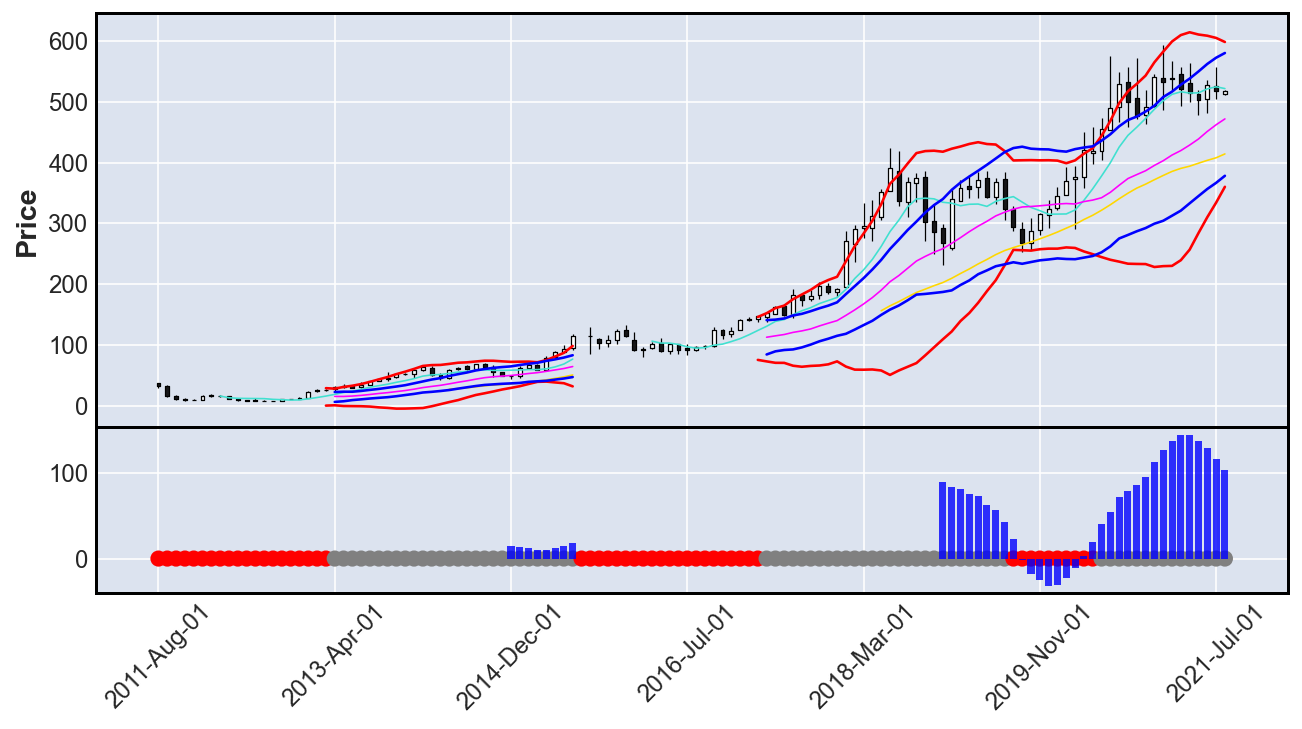

In [44]:
import panel as pn
from panel.interact import interact

pn.extension()

def figure_stock_mo(stock):
    apds = [mpf.make_addplot(ticker_dict_1mo[stock]['value'], panel=1, type='bar', color=colors_mo, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(ticker_dict_1mo[stock]), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in ticker_dict_1mo[stock]['squeeze_off']], secondary_y=False),
            mpf.make_addplot(ticker_dict_1mo[stock][['upper_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1mo[stock][['lower_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1mo[stock][['upper_KC']], color = 'blue'),
            mpf.make_addplot(ticker_dict_1mo[stock][['lower_KC']], color = 'blue')]

    # plot ohcl with subplots
    fig, axes = mpf.plot(ohcl_mo[stock], 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

ticker = monthly_data["ticker"].unique()
interact(figure_stock_mo, stock=ticker)